# 5. Resampling Methods

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline
plt.style.use('seaborn-white')

In [36]:
import sklearn.linear_model as skl_lm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import (
    KFold,
    LeaveOneOut,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import PolynomialFeatures

### Figure 5.2 - Validation Set Approach

[Using Polynomial feature generation in scikit-learn](https://scikit-learn.org/dev/modules/preprocessing.html#generating-polynomial-features)

In [37]:
# load dataset
auto = pd.read_csv('../data/Auto.csv', na_values = '?').dropna()

In [83]:
t_prop = 0.5 # split the data set as half for trainning,half for testing.
p_order = np.arange(1, 11)
r_state = np.arange(0, 10)

X, Y = np.meshgrid(p_order, r_state, indexing= 'ij')
Z = np.zeros((p_order.size, r_state.size))

In [41]:
regr = skl_lm.LinearRegression()
# Generate 10 random splits of the dataset
for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(auto.horsepower.values.reshape(-1,1))
    
    X_train, X_test, y_train, y_test = train_test_split(X_poly, auto.mpg.ravel(),
                                                        test_size=t_prop, random_state=Y[i,j])
                                                                        
    regr.fit(X_train, y_train)
    pred = regr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

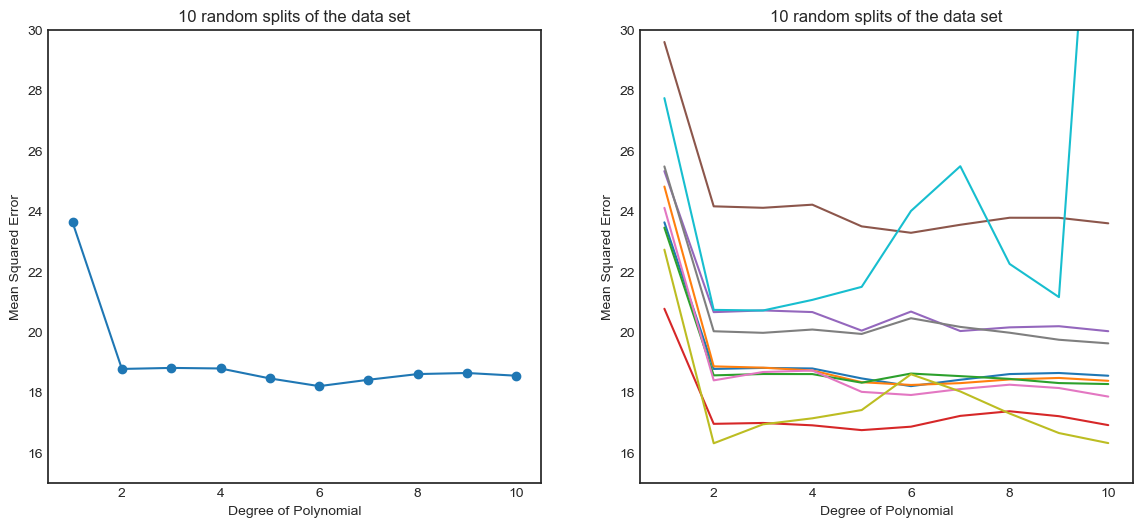

In [42]:
_, (ax1, ax2) = plt.subplots(1,2, figsize=(14,6), dpi=100)
#Left plot(first split)
ax1.plot(X.T[0], Z.T[0], '-o')
ax1.set_title('10 random splits of the data set')

# Right plot(all splits)
ax2.plot(X,Z)
ax2.set_title('10 random splits of the data set')

for ax in _.axes:
    ax.set(xlabel = 'Degree of Polynomial', ylabel = 'Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlim(0.5, 10.5)
    ax.set_xticks(range(2, 11, 2))

FIGURE 5.2. The validation set approach was used on the Auto data set in order to estimate the test error that results from predicting mpg using polynomial functions of horsepower.

Left: Validation error estimates for a single split into training and validation data sets. 

Right: The validation method was repeated ten times, each time using a different random split of the observations into a training set and a validation set. This illustrates the variability in the estimated test MSE that results from this approach.

Figure 5.4

In [43]:
# p_order, r_state
# LeaveOneOut CV
rege = skl_lm.LinearRegression()
loo = LeaveOneOut()
loo.get_n_splits(auto)
scores = list()


for i in p_order:
    poly = PolynomialFeatures(i)
    X_poly = poly.fit_transform(auto.horsepower.values.reshape(-1,1))
    score = cross_val_score(regr, X_poly, auto.mpg, 
                                                cv = loo, scoring = 'neg_mean_squared_error').mean()
    scores.append(score)

In [44]:
# k-fold CV
folds = 10
elements = len(auto.index)


X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))


regr = skl_lm.LinearRegression()

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(X[i,j])
    X_poly = poly.fit_transform(auto.horsepower.values.reshape(-1,1))
    kf_10 = KFold(n_splits=folds, shuffle=True)
    Z[i,j] = cross_val_score(regr, X_poly, auto.mpg,
                                                    cv = kf_10,scoring='neg_mean_squared_error').mean()

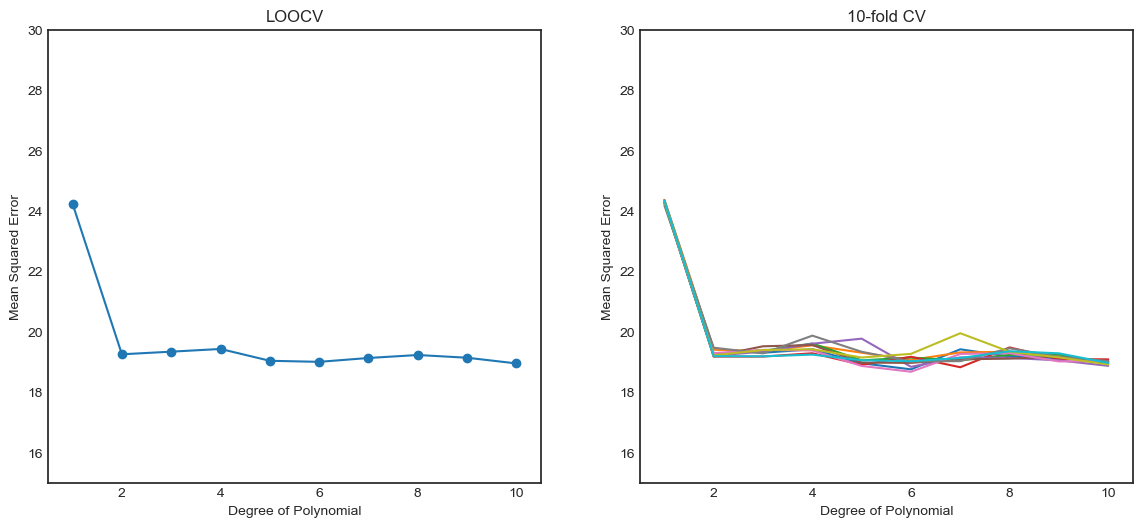

In [45]:
_, (ax1,ax2) = plt.subplots(1,2,figsize=(14,6),dpi=100)
# Note: cross_val_score() method return negative values for the scores.
# https://github.com/scikit-learn/scikit-learn/issues/2439

# Left plot
ax1.plot(p_order, np.array(scores) * -1,'-o')
ax1.set_title('LOOCV')

# Right plot
ax2.plot(X,Z*-1)
ax2.set_title('10-fold CV')

for ax in _.axes:
    ax.set(xlabel='Degree of Polynomial', ylabel='Mean Squared Error')
    ax.set_xlim(0.5, 10.5)
    ax.set_ylim(15,30)
    ax.set_xticks(range(2,11,2))

# The Validation Set Approach

In this lab, we explore the resampling techniques covered in this chapter. Some of the commands in this lab may take a while to run on your computer.

We explore the use of the validation set approach in order to estimate the test error rates that result from fitting various linear models on the `Auto` data set.

Before we begin, we use the np.seed() function in order to set a seed for Python's random number generator, so that the the results are reproducible. It is generally a good idea to set a random seed when performing an analysis such as cross-validation that contains an element of randomness, so that the results obtained can be reproduced precisely at a later time.

We begin by splitting the set of observations into two halves, by selecting a random subset of 196 observations out of the original 39

In [46]:
np.random.seed(0)

auto_train = auto.sample(frac=0.5)
auto_test = auto.drop(auto_train.index)

We then fit a linear regression using only the observations corresponding to the training set.

In [47]:
def cv(f):
    lm_fit = smf.ols(f, auto_train).fit()
    cv = np.mean((auto_test.mpg - lm_fit.predict(auto_test))**2)
    print(cv)

In [48]:
f = 'mpg ~ horsepower'
cv(f)

24.397230304032295


We now use the predict() function to estimate the response for all 392 observations, and we use the mean() function to calculate the MSE of the 196 observations in the validation set.

Therefore, the estimated test MSE for the linear regression fit is 24.39. We can also estimate the test error for the quadratic and cubic regressions.

In [49]:
f = 'mpg ~ horsepower + np.power(horsepower,2)'
cv(f)

19.243963562139115


In [50]:
f = 'mpg ~ horsepower + np.power(horsepower,2) + np.power(horsepower,3)'
cv(f)

19.200464168637158


These error rates are 19.24 and 19.20, respectively. If we choose a different training set instead, then we will obtain somewhat different errors on the validation set.

# Leave-One-Out Cross-Validation

In the above validation approach, it was easy to use the statsmodels api to construct models and then calculate the MSE using the validation set approach. However, statsmodels does not have direct support for cross-validations i.e. LOOCV or K-fold. We will use the sklearn module here.

In [51]:
def cv_curve(X, y, orders, cv_n=10, loocv=False):
    orders = np.arange(orders[0], orders[1])
    mse_est = np.array([])

    for index, order in enumerate(orders):
        poly = PolynomialFeatures(degree=order, interaction_only=False, include_bias=False)
        X_poly = poly.fit_transform(X)

        lr = LinearRegression()
        lr.fit(X, y)
        if loocv:
            cv_neg = cross_val_score(lr, X_poly, y, cv=len(X), scoring='neg_mean_squared_error')
        else:
            cv_neg = cross_val_score(lr, X_poly, y, cv=cv_n, scoring='neg_mean_squared_error')
        cv = -np.mean(cv_neg)

        print('CV {}: {}'.format(order, cv))
        mse_est = np.append(mse_est, cv)

    print('\nThe estimated test MSEs:\n{}'.format(mse_est))

    fig , ax = plt.subplots(figsize=(6, 4))
    ax.plot(orders,mse_est,linestyle = '-.', marker='o', color='k')
    ax.set(xlabel='Polynomial Order')
    ax.set(ylabel='LOOCV Error Rate')

/var/folders/1q/m8l_wvxd5dl8kccgv4xrsxtr0000gn/T/ipykernel_37778/2580132022.py:2: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  X = X[:, np.newaxis]


CV 1: 24.231513517929226
CV 2: 19.24821312448967
CV 3: 19.33498406402931
CV 4: 19.42443031024277
CV 5: 19.03321248615882

The estimated test MSEs:
[24.23151352 19.24821312 19.33498406 19.42443031 19.03321249]


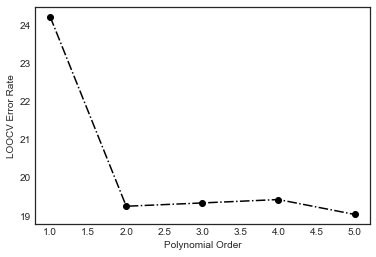

In [52]:
X = auto.horsepower
X = X[:, np.newaxis]
y = auto.mpg

cv_curve(X, y, orders=(1,6), loocv=True)

We see a sharp drop in the estimated test MSE between the linear and quadratic fits, but then no clear improvement from using higher-order polynomials.

# k-Fold Cross Validation

The same functions can also be used to implement k-fold CV. Below we use k = 10, a common choice for k, on the Auto data set. We simply copy the lines of code above using 10 folds instead of n folds in the cross-validation to be explicit.

CV 1: 27.439933652339874
CV 2: 21.235840055802225
CV 3: 21.33660618322788
CV 4: 21.35388698195473
CV 5: 20.905641650770082
CV 6: 20.779180086179668
CV 7: 20.990939391569672
CV 8: 21.077615424551695
CV 9: 21.036905853431772

The estimated test MSEs:
[27.43993365 21.23584006 21.33660618 21.35388698 20.90564165 20.77918009
 20.99093939 21.07761542 21.03690585]


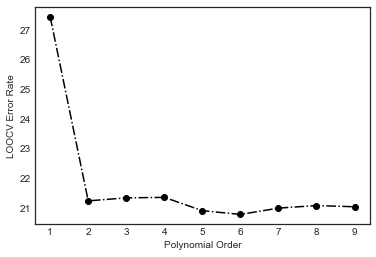

In [53]:
cv_curve(X, y, orders=(1,10), cv_n=10)

Notice that the computation time is much shorter than that of LOOCV. (In principle, the computation time for LOOCV for a least squares linear model should be faster than for k-fold CV, due to the availability of the formula (5.2) for LOOCV; however, unfortunately the cv function does not make use of this formula.) We still see little evidence that using cubic or higher-order polynomial terms leads to lower test error than simply using a quadratic fit.

# The Bootstrap

We illustrate the use of the bootstrap in the simple example of Section 5.2, as well as on an example involving estimating the accuracy of the linear regression model on the Auto data set.

## Estimating the Accuracy of a Statistic of Interest

One of the great advantages of the bootstrap approach is that it can be applied in almost all situations. No complicated mathematical calculations are required. Performing a bootstrap analysis in Python entails only two steps. First, we must create a function that computes the statistic of interest. Second, we define the boot() function to perform the bootstrap by repeatedly sampling observations from the data set with replacement.

The Portfolio data set is described in Section 5.2. To illustrate the use of the bootstrap on this data, we must first create a function, alpha(), which takes as input the (X, Y) data as well as a vector indicating which observations should be used to estimate α. The function then outputs the estimate for α based on the selected observations.

In [54]:
portfolio = pd.read_csv('../data/Portfolio.csv', index_col=0)
portfolio.head()

,X,Y
1,-0.895251,-0.234924
2,-1.562454,-0.885176
3,-0.417090,0.271888
4,1.044356,-0.734198
5,-0.315568,0.841983


In [55]:
def alpha(df, indices):

    X = df.X[indices].values
    Y = df.Y[indices].values
    
    return (np.var(Y) - np.cov(X,Y)[0][1])/(np.var(X) + np.var(Y) - 2*np.cov(X,Y)[0][1])

This function returns, or outputs, an estimate for α based on applying (5.7) to the observations indexed by the argument index. For instance, the following command tells Python to estimate α using all 100 observations.

In [56]:
alpha(portfolio, portfolio.index)

0.5766511516104116

The next command uses the sample() function to randomly select 100 observations from the range 1 to 100, with replacement. This is equivalent to constructing a new bootstrap data set and recomputing $\hat\alpha$ based on the new data set.

In [57]:
np.random.seed(0)
indices = np.random.choice(portfolio.index, 100, replace=True)
alpha(portfolio, indices)

0.560336658007497

We can implement a bootstrap analysis by performing this command many times, recording all of the corresponding estimates for α, and computing the resulting standard deviation.

In [58]:
def boot(data, statsfunc, n_bootstrap=1000, sample_size=100, seed=0):
    np.random.seed(seed)
    stat_samples = []
    for i in range(n_bootstrap):
        indices = np.random.choice(data.index, sample_size, replace=True)
        stat_samples.append(statsfunc(data, indices))
    
    se_estimated = np.std(stat_samples, axis=0)
    print('Original alpha: {}'.format(stat_samples[0]))
    print('\nBootstrapped Std. Error(s): {}'.format(se_estimated))

In [59]:
boot(portfolio, alpha, 1000, 100)

Original alpha: 0.560336658007497

Bootstrapped Std. Error(s): 0.08980409161302538


The final output shows that using the original data, $\hat\alpha = 0.5603$, and that the bootstrap estimate for $SE(\hat\alpha)$ is 0.0898.

### Estimating the Accuracy of a Linear Regression Model

The bootstrap approach can be used to assess the variability of the coefficient estimates and predictions from a statistical learning method. Here we use the bootstrap approach in order to assess the variability of the estimates for $\beta_0$ and $\beta_1$, the intercept and slope terms for the linear regression model that uses horsepower to predict mpg in the Auto data set. We will compare the estimates obtained using the bootstrap to those obtained using the formulas for $SE(\hat\beta_0)$ and $SE(\hat\beta_1)$ described in Section 3.1.2.

We first create a simple function, boot_fn(), which takes in the Auto data set as well as a set of indices for the observations, and returns the intercept and slope estimates for the linear regression model. We then apply this
function to the full set of 392 observations in order to compute the estimates of $\beta_0$ and $\beta_1$ on the entire data set using the usual linear regression coefficient estimate formulas from Chapter 3.

In [60]:
def boot_fn(df, indices):
    X = df.horsepower[indices].values
    X = sm.add_constant(X)
    y = df.mpg[indices].values
    lm_fit = sm.OLS(y, X).fit()
    
    return lm_fit.params

In [61]:
boot_fn(auto, auto.index)

array([39.93586102, -0.15784473])

The boot_fn() function can also be used in order to create bootstrap estimates for the intercept and slope terms by randomly sampling from among the observations with replacement. Here we give two examples.

In [62]:
np.random.seed(0)
indices = np.random.choice(auto.index, len(auto), replace=True)
boot_fn(auto, indices)

array([40.48043887, -0.16156162])

In [63]:
np.random.seed(1)
indices = np.random.choice(auto.index, len(auto), replace=True)
boot_fn(auto, indices)

array([39.65847877, -0.15589835])

Next, we use the boot() function to compute the standard errors of 1,000 bootstrap estimates for the intercept and slope terms.

In [64]:
boot(auto, boot_fn, n_bootstrap=1000, sample_size=len(auto))

Original alpha: [40.48043887 -0.16156162]

Bootstrapped Std. Error(s): [0.85288648 0.00726551]


This indicates that the bootstrap estimate for $SE(\hat\beta_0)$ is 0.88, and that the bootstrap estimate for $SE(\hat\beta_1)$ is 0.0076. As discussed in Section 3.1.2, standard formulas can be used to compute the standard errors for the
regression coefficients in a linear model. These can be obtained using the summary() function.

In [65]:
smf.ols('mpg~horsepower', auto).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           7.03e-81
Time:                        07:16:16   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     39.9359      0.717     55.660      0.000      38.525      41.347
horsepower    -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The standard error estimates for $\hat\beta_0$ and $\hat\beta_1$ obtained using the formulas from Section 3.1.2 are 0.717 for the intercept and 0.0064 for the slope. Interestingly, these are somewhat different from the estimates obtained using the bootstrap. Does this indicate a problem with the bootstrap? In fact, it suggests the opposite. Recall that the standard formulas given in Equation 3.8 on page 66 rely on certain assumptions. For example, they depend on the unknown parameter $\sigma^2$, the noise variance. We then estimate $\sigma^2$ using the RSS. Now although the formula for the standard errors do not rely on the linear model being correct, the estimate for $\sigma^2$ does. We see in Figure 3.8 on page 91 that there is a non-linear relationship in the data, and so the residuals from a linear fit will be inflated, and so will $\sigma^2$. Secondly, the standard formulas assume (somewhat unrealistically) that the $x_i$ are fixed, and all the variability comes from the variation in the errors $\epsilon_i$. The bootstrap approach does not rely on any of these assumptions, and so it is likely giving a more accurate estimate of the standard errors of $\hat\beta_0$ and $\hat\beta_1$ than is the summary() function.

Below we compute the bootstrap standard error estimates and the standard linear regression estimates that result from fitting the quadratic model to the data. Since this model provides a good fit to the data (Figure 3.8), there is now a better correspondence between the bootstrap estimates and the standard estimates of $SE(\hat\beta_0)$, $SE(\hat\beta_1)$ and $SE(\hat\beta_2)$.

In [66]:
def boot_fn(df, indices):
    X = np.column_stack([df.horsepower[indices].values, df.horsepower[indices].values**2])
    X = sm.add_constant(X)
    y = df.mpg[indices].values
    lm_fit = sm.OLS(y, X).fit()
    return lm_fit.params

boot(auto, boot_fn, n_bootstrap=1000, sample_size=len(auto))

Original alpha: [ 6.00043631e+01 -5.13312838e-01  1.38152821e-03]

Bootstrapped Std. Error(s): [2.08470089e+00 3.30784323e-02 1.19428146e-04]


In [67]:
smf.ols('mpg ~ horsepower + np.power(horsepower, 2)', auto).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.686
Method:                 Least Squares   F-statistic:                     428.0
Date:                Sun, 22 Aug 2021   Prob (F-statistic):           5.40e-99
Time:                        07:16:18   Log-Likelihood:                -1133.2
No. Observations:                 392   AIC:                             2272.
Df Residuals:                     389   BIC:                             2284.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  56.9001      1.800     31.604      0.000      53.360      60.440
horsepower                 -0.4662      0.031    -14.978      0.000      -0.527      -0.405
np.power(horsepower, 2)     0.0012      0.000     10.080      0.000       0.001       0.001
==============================================================================
Omnibus:                       16.158   Durbin-Watson:                   1.078
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.662
Skew:                           0.218   Prob(JB):                     2.20e-07
Kurtosis:                       4.299   Cond. No.                     1.29e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Conceptual

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import seaborn as sns; sns.set()
%matplotlib inline

In [69]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

## 2. Bootstrap sample

We will now derive the probability that a given observation is part of a bootstrap sample. Suppose that we obtain a bootstrap sample from a set of n observations.

### (a)-(c)

(a) What is the probability that the first bootstrap observation is not the jth observation from the original sample? Justify your answer.

(b) What is the probability that the second bootstrap observation is not the jth observation from the original sample?

(c) Argue that the probability that the jth observation is not in the bootstrap sample is $(1 − 1/n)^n$.

(a) $1-1/n$

(b) $1-1/n$

(c) $(1-1/n)^n$

### (d)-(f)

(d) When n = 5, what is the probability that the jth observation is in the bootstrap sample?

(e) When n = 100, what is the probability that the jth observation is in the bootstrap sample?

(f) When n = 10, 000, what is the probability that the jth observa- tion is in the bootstrap sample?

In [70]:
1-(1-1/5)**5

0.6723199999999999

In [71]:
1-(1-1/100)**100

0.6339676587267709

In [72]:
1-(1-1/10000)**10000

0.6321389535670295

In [73]:
def prob_j_in_sample(n):
    return 1 - (1 - 1/n)**n

x = np.arange(1, 100000)
y = np.array([prob_j_in_sample(n) for n in x])

ax.plot(x, y)
ax.set(xlabel='n')
ax.set(ylabel='probability')

[Text(613.8181818181816, 0.5, 'probability')]

### (h) 

We will now investigate numerically the probability that a bootstrap sample of size n = 100 contains the jth observation. Here j = 4. We repeatedly create bootstrap samples, and each time we record whether or not the fourth observation is contained in the bootstrap sample.

In [74]:
np.random.seed(0)

store = []

for i in np.arange(1, 10000):
    j_4 = np.sum((np.random.randint(1, 101, size=100) == 4))
    store.append(j_4>0)

np.mean(store)

0.6325632563256326

# Applied

## 5. Logistic regression

In Chapter 4, we used logistic regression to predict the probability of default using income and balance on the Default data set. We will now estimate the test error of this logistic regression model using the validation set approach. Do not forget to set a random seed before beginning your analysis.

In [75]:
default_df = pd.read_csv('../data/Default.csv', index_col='Unnamed: 0')
default_df = default_df.reset_index().drop('index', axis=1)

assert default_df.isna().sum().sum() == 0

default_df = pd.get_dummies(default_df, dtype=np.float64).drop(['default_No', 'student_No'], axis=1)

default_df.head()

,balance,income,default_Yes,student_Yes
0,729.526495,44361.625074,0.0,0.0
1,817.180407,12106.134700,0.0,1.0
2,1073.549164,31767.138947,0.0,0.0
3,529.250605,35704.493935,0.0,0.0
4,785.655883,38463.495879,0.0,0.0


### (a) Fit

Fit a logistic regression model that uses income and balance to predict default.

In [76]:
f = 'default_Yes ~ income + balance'

logit_fit = smf.logit(f, default_df).fit()
logit_fit.summary()

Optimization terminated successfully.
         Current function value: 0.078948
         Iterations 10


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            default_Yes   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Sun, 22 Aug 2021   Pseudo R-squ.:                  0.4594
Time:                        07:16:18   Log-Likelihood:                -789.48
converged:                       True   LL-Null:                       -1460.3
Covariance Type:            nonrobust   LLR p-value:                4.541e-292
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -11.5405      0.435    -26.544      0.000     -12.393     -10.688
income      2.081e-05   4.99e-06      4.174      0.000     1.1e-05    3.06e-05
balance        0.0056      0.000     24.835      0.000       0.005       0.006
==============================================================================

Possibly complete quasi-separation: A fraction 0.14 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

In [77]:
predictors = ['income', 'balance']

X = default_df[predictors]
y = default_df['default_Yes']

log_clf = LogisticRegression()
model = log_clf.fit(X, y)

In [78]:
log_clf.coef_

array([[2.08091985e-05, 5.64710797e-03]])

### (b) Estimate the test error

Using the validation set approach, estimate the test error of this model. In order to do this, you must perform the following steps:


i. Split the sample set into a training set and a validation set.

ii. Fit a multiple logistic regression model using only the training observations.

iii. Obtain a prediction of default status for each individual in the validation set by computing the posterior probability of default for that individual, and classifying the individual to the default category if the posterior probability is greater than 0.5.

iv. Compute the validation set error, which is the fraction of the observations in the validation set that are misclassified.

In [79]:
def classify(clf, data, coef=True, auc=False, roc_curve=False, conf_mat=False, conf_labels=['Down', 'Up']):
    X_train, X_test, y_train, y_test = data[0], data[1], data[2], data[3]

    model = clf.fit(X_train, y_train)
    if coef:
        print('parameters: {}'.format(clf.coef_))
    
    acc = clf.score(X_test, y_test)
    print('accuracy: {}'.format(acc))
    
    y_pred = clf.predict(X_test)
    precision = precision_score(y_test, y_pred)
    print('precision: {}'.format(precision))
    
    recall = recall_score(y_test, y_pred)
    print('recall: {}'.format(recall))
    
    mat = confusion_matrix(y_test, y_pred)
    print('confusion matrix \n{}'.format(mat))
    
    print('total error rate: {:.1%}'.format(1 - np.trace(mat) / np.sum(mat)))
    
    if auc:
        y_score = model.decision_function(X_test)
        auc = roc_auc_score(y_test, y_score)
        print('auc: {}'.format(auc))
    
    if roc_curve:
        plot_roc_curve(clf, X_test, y_test)
    
    if conf_mat:
        plot_confusion_matrix(clf, X_test, y_test, cmap=plt.cm.Blues, 
                              display_labels=conf_labels)
    
    return clf

In [80]:
predictors = ['income', 'balance']

X = default_df[predictors]
y = default_df['default_Yes']

data = train_test_split(X, y, test_size=0.5, random_state=0)

log_clf = LogisticRegression()
classify(log_clf, data)

parameters: [[1.57956908e-05 5.56457746e-03]]
accuracy: 0.971
precision: 0.8059701492537313
recall: 0.2903225806451613
confusion matrix 
[[4801   13]
 [ 132   54]]
total error rate: 2.9%


LogisticRegression()

### (c) Different splits

Repeat the process in (b) three times, using three different splits of the observations into a training set and a validation set. Comment on the results obtained.

### (d) 

Now consider a logistic regression model that predicts the probability of default using income, balance, and a dummy variable for student. Estimate the test error for this model using the validation set approach. Comment on whether or not including a dummy variable for student leads to a reduction in the test error rate.

In [81]:
predictors = ['income', 'balance', 'student_Yes']

X = default_df[predictors]
y = default_df['default_Yes']

data = train_test_split(X, y, test_size=0.5, random_state=0)

log_clf = LogisticRegression()
classify(log_clf, data)

parameters: [[-1.38355453e-04  4.04131793e-03 -3.84660550e+00]]
accuracy: 0.9644
precision: 0.5769230769230769
recall: 0.16129032258064516
confusion matrix 
[[4792   22]
 [ 156   30]]
total error rate: 3.6%


LogisticRegression()

## 6. 

We continue to consider the use of a logistic regression model to predict the probability of default using income and balance on the Default data set. In particular, we will now compute estimates for the standard errors of the income and balance logistic regression coefficients in two different ways: 

(1) using the bootstrap, and (2) using the standard formula for computing the standard errors in the glm() function. Do not forget to set a random seed before beginning your analysis.

### (a) 

Using the summary() and glm() functions, determine the estimated standard errors for the coefficients associated with income and balance in a multiple logistic regression model that uses both predictors.

In [82]:
response   = 'default_Yes'
predictors = ['income', 'balance']

X_all = sm.add_constant(np.array(default_df[predictors]))
y_all = np.array(default_df[response])

model_logit = smf.logit(y_all, X_all).fit(disp=False) 

print(model_logit.summary())

statsmodels_est = pd.DataFrame({'coef_sm': model_logit.params, 'SE_sm': model_logit.bse})
statsmodels_est

PatsyError: model is missing required outcome variables

### (b) boot.fn()

Write a function, boot.fn(), that takes as input the Default data set as well as an index of the observations, and that outputs the coefficient estimates for income and balance in the multiple logistic regression model.

In [ ]:
def boot_fn(df, idx):
    response   = 'default_Yes'
    predictors = ['income', 'balance']
    
    X = sm.add_constant(np.array(df[predictors].loc[idx]))
    y = np.array(df[response].loc[idx]) 

    model_logit = smf.Logit(y, X).fit(disp=False)
    return model_logit.params

### (c) boot()

Use the boot() function together with your boot.fn() function to estimate the standard errors of the logistic regression coefficients for income and balance.

### (d) 

Comment on the estimated standard errors obtained using the glm() function and using your bootstrap function.